# Activity recognition on the Capture24 dataset

We aim to build a machine learning model to recognize
activities from wrist-worn accelerometer measurements.
Our baseline model is a random forest trained to classify instances of 30
seconds of activity, trained on the hand-crafted features `X_feats`. Further,
we use a Hidden Markov Model to account for temporal dependencies to smooth
the predictions of the random forest.

###### Setup

In [1]:
import numpy as np
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import utils  # contains helper functions for this workshop -- check utils.py

# For reproducibility
np.random.seed(42)

# A function to plot the activity timeseries of a participant
def plot_activity(X, y, pid, time, ipid=3):
    mask = pid == ipid
    return utils.plot_activity(X[:,0][mask], y[mask], time[mask])

 ###### Load dataset and hold out some instances for testing 

In [2]:
# data = np.load('capture24.npz', allow_pickle=True)
data = np.load('capture24_small.npz', allow_pickle=True)
print("Data contents:", data.files)
X, y, pid, time = data['X_feats'], data['y'], data['pid'], data['time']

# Hold out some participants for testing the model
pids_test = [2, 3]  # participants 2 & 3
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
X_train, y_train, pid_train, time_train = \
    X[mask_train], y[mask_train], pid[mask_train], time[mask_train]
X_test, y_test, pid_test, time_test = \
    X[mask_test], y[mask_test], pid[mask_test], time[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Data contents: ['X_feats', 'y', 'pid', 'time', 'annotation']
Shape of X_train: (6025, 125)
Shape of X_test: (4991, 125)


 ###### Train a random forest classifier 


--- Random forest performance ---
Cohen kappa score: 0.7788610717203537
Accuracy score: 0.8693754047475492
Confusion matrix:
 [[1867   46    2   11    2]
 [ 141 2022    1   40   17]
 [  20   85    1   19    3]
 [   3   82    3  170   52]
 [   7   56    3   55  283]]


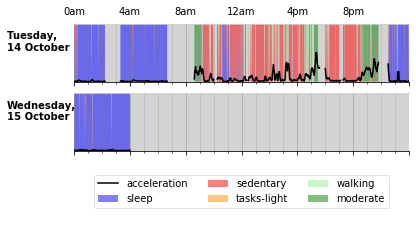

In [3]:
# Argument oob_score=True to be used for HMM smoothing (see below)
classifier = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=2)
classifier.fit(X_train, y_train)

y_test_pred = classifier.predict(X_test)
print("\n--- Random forest performance ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_pred, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_pred, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

# Activity plot for participant #3
fig, _ = plot_activity(X_test, y_test_pred, pid_test, time_test, ipid=3)
fig.show()

## Accounting for temporal dependencies to smooth the predictions
The random forest classifier performs descently well.
However, the model does not account for temporal dependencies since we simply
trained it to independently classify intervals of 30 seconds of activity.
This can be seen in the activity plot where the sleep period is not smooth.

###### Mode filtering
To account for the temporal component, we first consider smoothing the predictions
by applying a mode filter, i.e. we pass a window (here of size 3) through the
predicted activity timeseries and pick the most popular activity within the
window.

**Note:** As mentioned before, the provided arrays `X_feats`, `X_raw`, `y`, etc. are so that consecutive rows correspond to continuous measurements in time for a same participant.
Discontinuities will naturally occur at the edges between two participants.
Interrupts in the measurement within a same participant may also occur (e.g. device run out of battery).
In the following time smoothing approaches we do not account for these interrupts &mdash; the number of these are negligible so we ignore them. You could properly account for these by looking at the `time` and `pid` arrays.


--- Random forest performance with mode filtering ---
Cohen kappa score: 0.8048933644255409
Accuracy score: 0.8867618707338678
Confusion matrix:
 [[1902   23    0    3    0]
 [ 108 2080    0   28    5]
 [  20   95    0   13    0]
 [   4  101    3  165   37]
 [   5   66    1   47  285]]


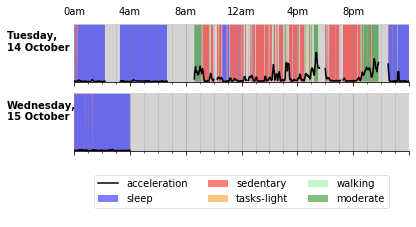

In [4]:
y_test_modefilt = mode(
    np.vstack((y_test_pred[:-2], y_test_pred[1:-1], y_test_pred[2:])),
    axis=0)[0].ravel()
y_test_modefilt = np.concatenate(([y_test_pred[0]], y_test_modefilt, [y_test_pred[-1]]))
print("\n--- Random forest performance with mode filtering ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_modefilt, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_modefilt, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_modefilt))

fig, _ = plot_activity(X_test, y_test_modefilt, pid_test, time_test, ipid=3)
fig.show()

###### Hidden Markov Model

We see that the simple mode smoothing improves both accuracy and kappa
scores and the activity plot is now smoother.

A more principled approch is to use a Hidden Markov Model (HMM). Here we
assume that the random forest predictions are mere "observations" of the
"hidden ground truth".
HMM requires that we obtain prior, emission and transition matrices. We can
compute these using the ground truth labels `y_train` together with the
classifier's probabilistic predictions on the training set (`predict_proba()`).
We use our utility functions `train_hmm()` and `viterbi()` to obtain these matrices and smoothing &mdash; see `utils.py` for details.


--- Random forest performance with HMM smoothing (in-bag estimate) ---
Cohen kappa score: 0.8397923539428707
Accuracy score: 0.9061450912961598
Confusion matrix:
 [[1916    8    0    4    0]
 [  65 2118    0   37    1]
 [  17   90    0   20    1]
 [   0   80    0  185   45]
 [   0   35    0   60  309]]


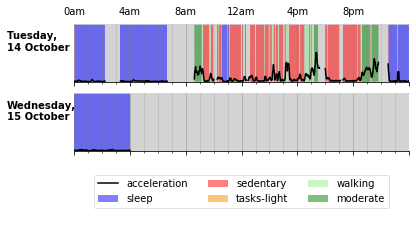

In [5]:
Y_train_pred = classifier.predict_proba(X_train)  # probabilistic predictions -- this is a (N,5) array
prior, emission, transition = utils.train_hmm(Y_train_pred, y_train)  # HMM training step
y_test_hmm = utils.viterbi(y_test_pred, prior, transition, emission)  # smoothing
print("\n--- Random forest performance with HMM smoothing (in-bag estimate) ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_hmm, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_hmm, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_hmm))

fig, _ = plot_activity(X_test, y_test_hmm, pid_test, time_test, ipid=3)
fig.show()

The HMM smoothing further improves the scores and the activity plot is even smoother.

Instead of using `predict_proba` on the same set that the model was trained on, the model conveniently provides out-of-bag probability estimates on the training set (enabled by passing the `oob_score=True` argument), accessible via the attribute `oob_decision_function_`. These estimations are closer to the actual out-of-sample performance of the model. We can use these to re-calculate the HMM parameters:


--- Random forest performance with HMM smoothing (out-of-bag estimate) ---
Cohen kappa score: 0.8306725755472264
Accuracy score: 0.9014332715511787
Confusion matrix:
 [[1916    8    0    4    0]
 [  65 2132    0   20    4]
 [  17   98    0   13    0]
 [   0  105    0  141   64]
 [   0   40    0   50  314]]


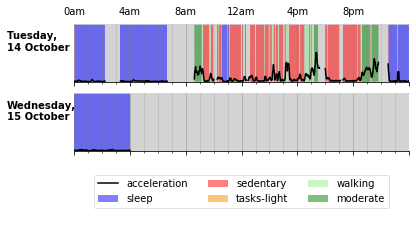

In [6]:
Y_oob = classifier.oob_decision_function_  # probabilistic predictions -- this is a (N,5) array
prior, emission, transition = utils.train_hmm(Y_oob, y_train)  # HMM training step
y_test_hmm_oob = utils.viterbi(y_test_pred, prior, transition, emission)  # smoothing
print("\n--- Random forest performance with HMM smoothing (out-of-bag estimate) ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_hmm_oob, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_hmm_oob, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_hmm_oob))

fig, _ = plot_activity(X_test, y_test_hmm, pid_test, time_test, ipid=3)
fig.show()

## Is a simple logistic regression enough?


--- Logistic regression performance ---
Cohen kappa score: 0.44711688491476204
Accuracy score: 0.6697446089487358
Confusion matrix:
 [[1761  155    4    1    7]
 [ 854 1316    1   31   19]
 [  26   84    0   14    4]
 [   8  152    2  102   46]
 [   8  155    0   56  185]]


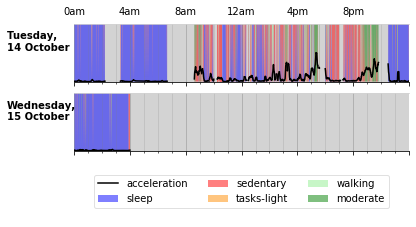

In [7]:
classifier_LR = LogisticRegression(
    random_state=42, solver='saga', multi_class='multinomial', max_iter=10000, n_jobs=2)
classifier_LR.fit(X_train, y_train)
y_test_LR = classifier_LR.predict(X_test)
print("\n--- Logistic regression performance ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_LR, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_LR, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_LR))

fig, _ = plot_activity(X_test, y_test_LR, pid_test, time_test, ipid=3)
fig.show()

###### HMM smoothing on the logistic regression predictions


--- Logistic regression performance with HMM smoothing ---
Cohen kappa score: 0.5559490211659159
Accuracy score: 0.7366554267807031
Confusion matrix:
 [[1833   93    1    1    0]
 [ 697 1505    0   18    1]
 [  19  101    0    8    0]
 [   2  152    0  104   52]
 [   0   86    0   52  266]]


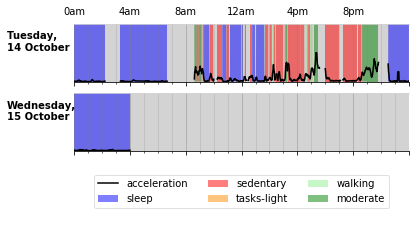

In [8]:
Y_train_LR_pred = classifier_LR.predict_proba(X_train)  # probabilistic predictions -- this is a (N,5) array
prior, emission, transition = utils.train_hmm(Y_train_LR_pred, y_train)  # HMM training step
y_test_LR_hmm = utils.viterbi(y_test_LR, prior, transition, emission)  # smoothing
print("\n--- Logistic regression performance with HMM smoothing ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_LR_hmm, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_LR_hmm, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_LR_hmm))

fig, _ = plot_activity(X_test, y_test_LR_hmm, pid_test, time_test, ipid=3)
fig.show()

HMM on top of the logistic regression model substantially improves its
performance. But although the predictions are smooth, the performance is
still much worse than the random forest model.

## Conclusion

Random forest on the hand-crafted features shows a very strong performance.
Smoothing the predictions to account for temporal dependencies reliably
improves performance. A simple logistic regression did not seem to perform as
well as the random forest (at least for the hyperparameters considered).

In the next sections, we ask you to improve our baseline using a variety of
approaches from the machine learning literature.
Note that now that we have repeatedly evaluated on the test set and taken decisions
based on it (we have abused the test set), the reported scores are no longer
an unbiased estimate of the general performance. A true test set will be
provided at the end of this workshop to truly assess the performance of your
model.

###### Ideas

- Tune hyperparameters of the random forest (`n_estimators`, `max_depth`,
`criterion`, etc.). See [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
- Tune the hyperparameters of the logistic regression (`penalty`, `C`, `max_iter`, etc.). See [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
- How would you select the best set of hyperparameters for a model?
- Can we improve performance by balancing the dataset?
- Given that the dataset is highly unbalanced, do we focus on accuracy or kappa score?

###### References
- [A nice lecture on validation](https://www.youtube.com/watch?v=o7zzaKd0Lkk&hd=1)